In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
from datetime import datetime
from sklearn.metrics import mean_squared_error


%matplotlib inline
plt.style.use('fivethirtyeight')          #Used for replicating graph styles from fivethirtyeight.com

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

from binance.client import Client

In [29]:
api_key = ""
secret_key="t"

client = Client(api_key,secret_key)

candles = client.get_klines(symbol='BTCUSDT',interval = Client.KLINE_INTERVAL_1MINUTE);

In [30]:
len(candles)

500

In [31]:
candles[499]      #time-open-high-low-close-volume-close_time

[1618010580000,
 '58039.99000000',
 '58041.71000000',
 '57995.36000000',
 '58004.58000000',
 '11.01249700',
 1618010639999,
 '638835.11735212',
 567,
 '5.40493900',
 '313532.71274180',
 '0']

In [32]:
#Fetching closing prices from candlesticks data

price = np.array([float(candles[i][4]) for i in range(500)])

In [33]:
#Fetching opening time from candlesticks data
time = np.array([int(candles[i][0]) for i in range(500)])

#Converting time to HH:MM:SS format
t = np.array([datetime.fromtimestamp(time[i]/1000).strftime('%H:%M:%S') for i in range(500)])

In [34]:
price.shape

(500,)

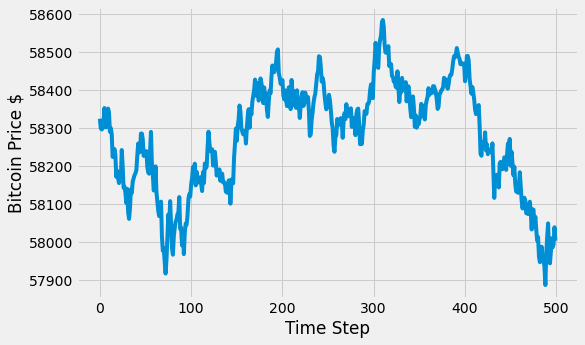

In [35]:
plt.figure(figsize=(8,5))
plt.xlabel("Time Step")
plt.ylabel("Bitcoin Price $")
plt.plot(price)

In [36]:
#Putting this data into a dataframe
timeframe = pd.DataFrame({'Time':t,'Price $BTC':price})
timeframe  #minute by minute price

,Time,Price $BTC
0,20:04:00,58325.32
1,20:05:00,58300.03
2,20:06:00,58297.00
3,20:07:00,58299.99
4,20:08:00,58309.91
...,...,...
495,04:19:00,58011.04
496,04:20:00,57987.36
497,04:21:00,57995.39
498,04:22:00,58039.98


In [37]:
price = price.reshape(500,1)

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [39]:
scaler.fit(price[:374])

StandardScaler()

In [40]:
price = scaler.transform(price)

In [41]:
#Putting the standardized data into dataframe according to input and target(output) columns for model training
df = pd.DataFrame(price.reshape(100,5),columns = ['First','Second','Third','Fourth','Target'])

In [42]:
df.head()

,First,Second,Third,Fourth,Target
0,0.244444,0.050941,0.027758,0.050635,0.126537
1,0.459753,0.073589,0.073283,0.289357,0.448505
2,0.379720,-0.016467,0.056833,-0.068879,-0.523368
3,-0.469426,-0.366822,-0.484806,-0.925446,-0.801724
4,-0.956970,-1.051235,-0.990712,-0.949242,-0.385262


In [43]:
#Split train and test data

x_train = df.iloc[:74,:4]
y_train = df.iloc[:74,-1]

x_test = df.iloc[75:99,:4]
y_test = df.iloc[75:99,-1]

In [44]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [45]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [46]:
x_train.shape, x_test.shape

((74, 4, 1), (24, 4, 1))

In [47]:
#Calibrating and initializing the prediction model

model = Sequential()

model.add(LSTM(20,return_sequences=True,input_shape=(4,1)))
model.add(LSTM(40,return_sequences=False))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse',optimizer='rmsprop')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4, 20)             1760      
_________________________________________________________________
lstm_3 (LSTM)                (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 11,561
Trainable params: 11,561
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.fit(x_train,y_train,batch_size=5,epochs=100)

Epoch 1/100
15/15 [==============================] - 3s 3ms/step - loss: 1.1432
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.4767
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.2131
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1426
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1263
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1374
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1052
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1258
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1334
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1401
Epoch 11/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1630
Epoch 12/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1277
Epoch 13/100
15/15 [=================

In [49]:
y_pred = model.predict(x_test)

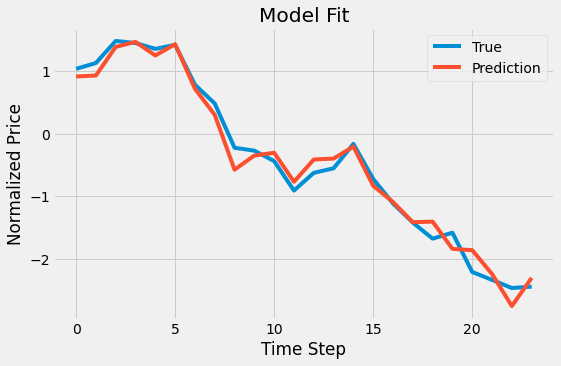

In [50]:
#Plotting the prediction vs actual graph for scaled data
plt.figure(figsize = [8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.plot(y_test,label = "True")
plt.plot(y_pred,label="Prediction")
plt.legend()
plt.show()

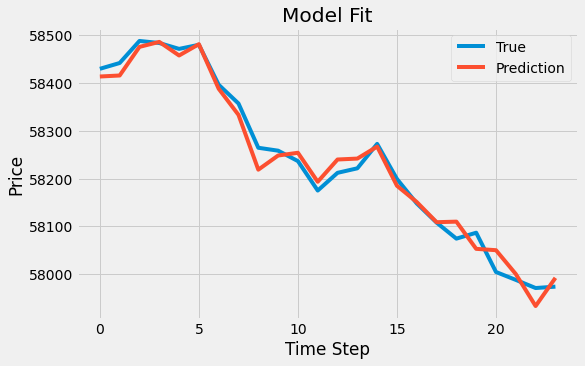

In [51]:
#Plotting the prediction vs actual graph for scaled data
plt.figure(figsize = [8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.plot(scaler.inverse_transform(y_test),label = "True")
plt.plot(scaler.inverse_transform(y_pred),label="Prediction")
plt.legend()
plt.show()

In [52]:
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(y_pred)))
print('Test Score : %2f RMSE' % (testScore))

Test Score : 22.840295 RMSE


In [53]:
from sklearn.metrics import r2_score

In [54]:
print('RSquared : ', '{:.2%}'.format(r2_score(y_test,y_pred)))

RSquared :  98.19%


In [29]:
model.save("Bitcoin_model.h5")